## Train experiments with a simple autoencoder as DR

In [1]:
%load_ext autoreload
%autoreload 2

## Initialization

Imports

In [2]:
import sys
sys.path.append('../')

import torch
from torch import nn
import matplotlib.pyplot as plt

# local imports
from setup import setup_device, setup_datamodule, load_model
from adapters.main import capture_convolution_layers
from dimensionality_reduction.feature_autoencoder import FeatureAutoencoder



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

nnUNet_raw_data_base is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
nnUNet_preprocessed is not defined and nnU-Net can not be used for preprocessing or training. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up.
RESULTS_FOLDER is not defined and nnU-Net cannot be used for training or inference. If this is not in

Set the device globally

In [3]:
device = setup_device('cuda:2')
print(device, type(device))

cuda:2 <class 'torch.device'>


Load a trained model

In [4]:
model = load_model('../pre-trained/trained_UNets/mnmv2-00-02_22-11-2024-v1.ckpt', device)

Loaded as Lightning module


Initialize mnmv2 dataset module

In [5]:
datamodule = setup_datamodule()

In [6]:
# no. of epochs for training
EPOCHS_COUNT = 50
LEARNING_RATE = 1e-3

# output dims of dim reduction
OUT_DIMS = 3

# display results for a selected sample
SAMPLE_ID = 5

In [7]:
# LAYER_ID = 10
# LAYER_ID = 110
LAYER_NAME = 'model.model.1.submodule.1.submodule.0.conv'

In [8]:
import wandb

BATCH_SIZE = 32
# Initialize wandb
wandb.init(project="simple-autoencoder-training", config={"learning_rate": LEARNING_RATE, "epochs": EPOCHS_COUNT, "batch_size": BATCH_SIZE})

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: vaklr (vaklr-bonn). Use `wandb login --relogin` to force relogin


### Preparation

Take the first batch from the datamodule

In [9]:
data_batch = next(iter(datamodule.val_dataloader()))

data_sample = data_batch['input']
data_sample.size() # [batch size, channels, width, hegiht]

torch.Size([32, 1, 256, 256])

Use hooks to capture hidden layer activations in the batch

In [10]:
wrapper, layer_names = capture_convolution_layers(model, device, data_sample)

In [11]:
# layer_samples = wrapper.layer_activations[layer_names[LAYER_ID]]
layer_samples = wrapper.layer_activations[LAYER_NAME]

print(f"shape of the selected layer ([COUNT, C, H, W]): {layer_samples.size()}")

shape of the selected layer ([COUNT, C, H, W]): torch.Size([32, 32, 64, 64])


In [12]:
BATCH_COUNT, C, H, W = layer_samples.detach().numpy().shape

## Experiments (single & batch)

Define a train function

In [19]:
def train_batch(autoencoder, num_epochs: int, samples, logger = None):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)

    for epoch in range(num_epochs):
        epoch_loss = .0
        optimizer.zero_grad()
        
        for image in samples:
            _latent, reconstructed = autoencoder(image)
            loss = criterion(reconstructed, image)
            epoch_loss += loss

        if logger:
                logger({ "epoch_loss": epoch_loss/len(samples) })

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(samples):.4f}")
        epoch_loss.backward()
        optimizer.step()

    return autoencoder


Define visualization functions:

In [14]:
def visualize(image):
    if image.shape[0] > 3:  # If more than 3 channels, average channels
        # return image.mean(axis=0)
        return image[0]
    else:  # If 3 or fewer channels, just transpose to match image format
        return image.transpose(1, 2, 0)  # [C, H, W] -> [H, W, C]

In [15]:
def plot_results(orig, reconstr, latent):
    # Create a side-by-side plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image
    axes[0].imshow(visualize(orig), cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Reconstructed Image
    axes[1].imshow(visualize(reconstr), cmap='gray')
    axes[1].set_title("Reconstructed Image")
    axes[1].axis("off")

    # Latent Representation (3 channels, like RGB)
    axes[2].imshow(latent.transpose(1, 2, 0))  # Transpose for [H, W, C]
    axes[2].set_title("Latent Representation")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

torch.Size([1, 256, 256])


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

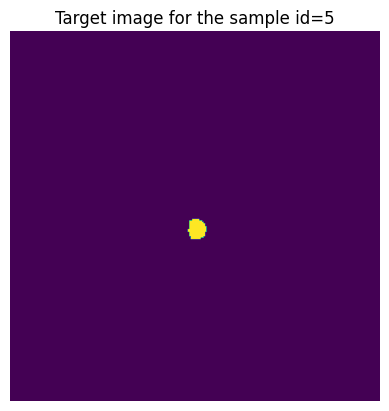

In [16]:
data_sample_target = data_batch['target'][SAMPLE_ID]
print(data_sample_target.size())

plt.imshow(data_sample_target.detach().numpy().transpose(1, 2, 0))
plt.title(f'Target image for the sample id={SAMPLE_ID}')
plt.axis("off")

### Single Layer Training

Create an instance of Autoencoder for training

In [17]:
BATCH_COUNT, C, H, W = layer_samples.detach().numpy().shape

single_autoencoder = FeatureAutoencoder(C, OUT_DIMS)

defined an autoencoder with input channels=32 and out channels=3


In [20]:
single_autoencoder = train_batch(single_autoencoder, EPOCHS_COUNT, [layer_samples[SAMPLE_ID]])

Epoch [1/50], Loss: 0.5899
Epoch [2/50], Loss: 0.5728
Epoch [3/50], Loss: 0.5474
Epoch [4/50], Loss: 0.5021
Epoch [5/50], Loss: 0.4439
Epoch [6/50], Loss: 0.4573
Epoch [7/50], Loss: 0.4182
Epoch [8/50], Loss: 0.3928
Epoch [9/50], Loss: 0.3921
Epoch [10/50], Loss: 0.3921
Epoch [11/50], Loss: 0.3861
Epoch [12/50], Loss: 0.3785
Epoch [13/50], Loss: 0.3758
Epoch [14/50], Loss: 0.3734
Epoch [15/50], Loss: 0.3643
Epoch [16/50], Loss: 0.3549
Epoch [17/50], Loss: 0.3493
Epoch [18/50], Loss: 0.3401
Epoch [19/50], Loss: 0.3279
Epoch [20/50], Loss: 0.3177
Epoch [21/50], Loss: 0.3083
Epoch [22/50], Loss: 0.2965
Epoch [23/50], Loss: 0.2861
Epoch [24/50], Loss: 0.2763
Epoch [25/50], Loss: 0.2671
Epoch [26/50], Loss: 0.2620
Epoch [27/50], Loss: 0.2558
Epoch [28/50], Loss: 0.2497
Epoch [29/50], Loss: 0.2435
Epoch [30/50], Loss: 0.2361
Epoch [31/50], Loss: 0.2314
Epoch [32/50], Loss: 0.2267
Epoch [33/50], Loss: 0.2225
Epoch [34/50], Loss: 0.2189
Epoch [35/50], Loss: 0.2147
Epoch [36/50], Loss: 0.2107
E

Show the results

In [21]:
selected_sample = layer_samples[SAMPLE_ID]
latent, reconstructed = single_autoencoder(selected_sample)

In [22]:
original_np = selected_sample.detach().numpy()
latent_np = latent.detach().numpy()
reconstructed_np = reconstructed.detach().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.5712996..3.847082].


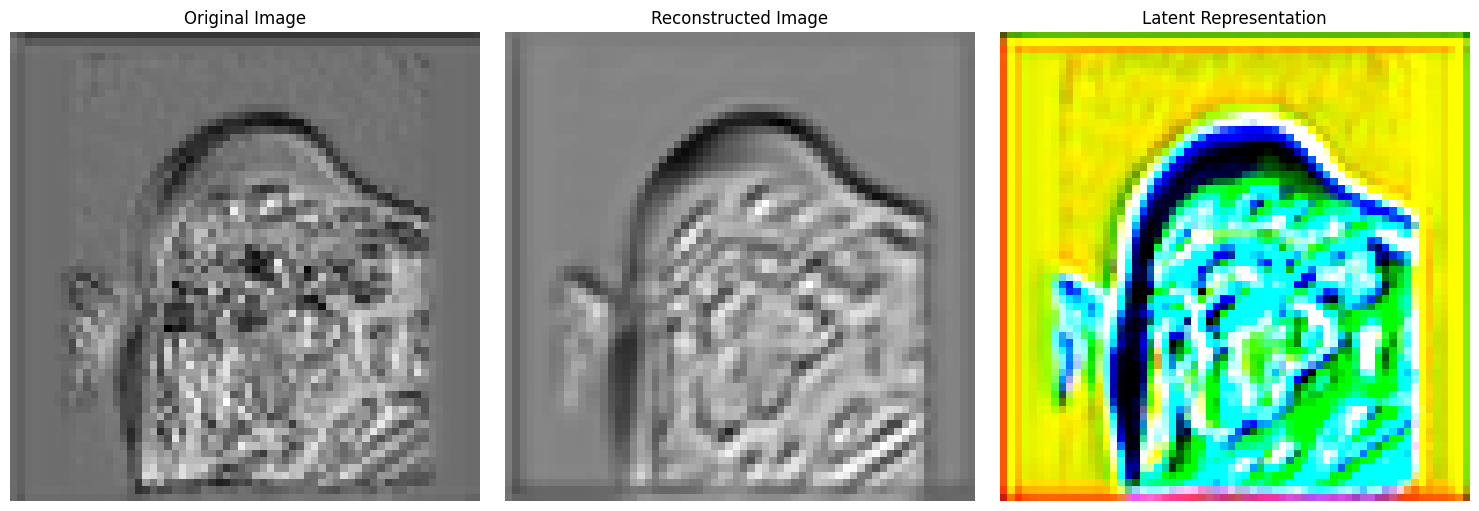

In [23]:
plot_results(original_np, reconstructed_np, latent_np)

In [24]:
import numpy as np

mse_error = np.mean((original_np - reconstructed_np) ** 2)

print(f"MSE Error: {mse_error.item()}")


MSE Error: 0.14254271984100342


### Single Batch Training

In [25]:
BATCH_COUNT, C, H, W = layer_samples.detach().numpy().shape

autoencoder_batch = FeatureAutoencoder(C, OUT_DIMS)

defined an autoencoder with input channels=32 and out channels=3


In [26]:
autoencoder_batch = train_batch(autoencoder_batch, EPOCHS_COUNT, layer_samples)

Epoch [1/50], Loss: 0.5962
Epoch [2/50], Loss: 0.5757
Epoch [3/50], Loss: 0.5508
Epoch [4/50], Loss: 0.5138
Epoch [5/50], Loss: 0.4638
Epoch [6/50], Loss: 0.4355
Epoch [7/50], Loss: 0.4328
Epoch [8/50], Loss: 0.3965
Epoch [9/50], Loss: 0.3801
Epoch [10/50], Loss: 0.3760
Epoch [11/50], Loss: 0.3722
Epoch [12/50], Loss: 0.3664
Epoch [13/50], Loss: 0.3607
Epoch [14/50], Loss: 0.3570
Epoch [15/50], Loss: 0.3564
Epoch [16/50], Loss: 0.3531
Epoch [17/50], Loss: 0.3465
Epoch [18/50], Loss: 0.3424
Epoch [19/50], Loss: 0.3408
Epoch [20/50], Loss: 0.3390
Epoch [21/50], Loss: 0.3367
Epoch [22/50], Loss: 0.3345
Epoch [23/50], Loss: 0.3327
Epoch [24/50], Loss: 0.3305
Epoch [25/50], Loss: 0.3272
Epoch [26/50], Loss: 0.3241
Epoch [27/50], Loss: 0.3215
Epoch [28/50], Loss: 0.3188
Epoch [29/50], Loss: 0.3154
Epoch [30/50], Loss: 0.3118
Epoch [31/50], Loss: 0.3083
Epoch [32/50], Loss: 0.3042
Epoch [33/50], Loss: 0.2996
Epoch [34/50], Loss: 0.2954
Epoch [35/50], Loss: 0.2911
Epoch [36/50], Loss: 0.2864
E

Show the results

In [27]:
selected_sample = layer_samples[SAMPLE_ID]
latent_batch, reconstructed_batch = autoencoder_batch(selected_sample)

In [28]:
original_batch_np = selected_sample.detach().numpy()
latent_batch_np = latent_batch.detach().numpy()
reconstructed_batch_np = reconstructed_batch.detach().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.5814223..3.927678].


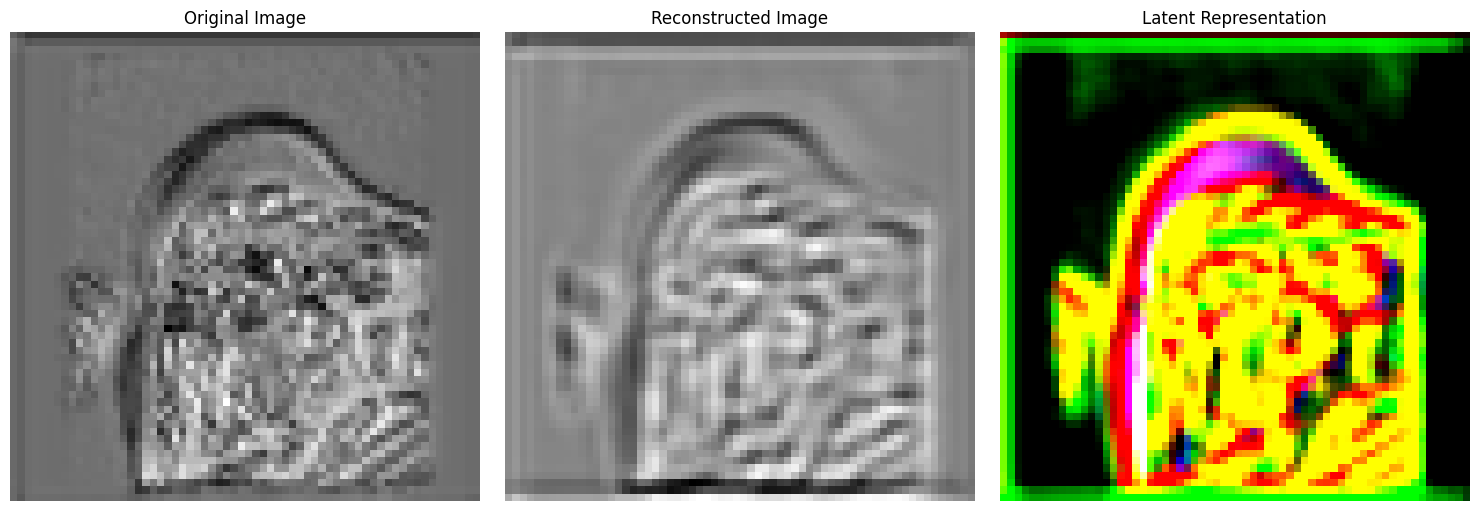

In [29]:
plot_results(original_batch_np, reconstructed_batch_np, latent_batch_np)

In [31]:
mse_error = np.mean((original_np - reconstructed_batch_np) ** 2)

print(f"MSE Error: {mse_error.item()}")

MSE Error: 0.1948249638080597


## Whole Dataset Training

### Train new autoencoded

In [32]:
from dimensionality_reduction.train import train_dr

In [33]:
autoencoder_dataset = FeatureAutoencoder(C, OUT_DIMS)

defined an autoencoder with input channels=32 and out channels=3


In [34]:
# Track model parameters
wandb.watch(autoencoder_dataset, log="all", log_freq=10)

In [37]:
train_dr(autoencoder=autoencoder_dataset, datamodule=datamodule, model=model, device=device,
                       logger=wandb.log, layer_names=[LAYER_NAME], num_epochs=EPOCHS_COUNT)

Epoch [1/50], Loss: 9.1481
Epoch [2/50], Loss: 7.0541
Epoch [3/50], Loss: 5.7120
Epoch [4/50], Loss: 4.2062
Epoch [5/50], Loss: 3.0434
Epoch [6/50], Loss: 2.3830
Epoch [7/50], Loss: 1.9952
Epoch [8/50], Loss: 1.7465
Epoch [9/50], Loss: 1.5674
Epoch [10/50], Loss: 1.4397
Epoch [11/50], Loss: 1.3943
Epoch [12/50], Loss: 1.2723
Epoch [13/50], Loss: 1.2007
Epoch [14/50], Loss: 1.1545
Epoch [15/50], Loss: 1.1166
Epoch [16/50], Loss: 1.0767
Epoch [17/50], Loss: 1.0434
Epoch [18/50], Loss: 1.0151
Epoch [19/50], Loss: 0.9921
Epoch [20/50], Loss: 0.9699
Epoch [21/50], Loss: 0.9417
Epoch [22/50], Loss: 0.9193
Epoch [23/50], Loss: 0.9131
Epoch [24/50], Loss: 0.9100
Epoch [25/50], Loss: 0.8829
Epoch [26/50], Loss: 0.8623
Epoch [27/50], Loss: 0.8486
Epoch [28/50], Loss: 0.8435
Epoch [29/50], Loss: 0.8315
Epoch [30/50], Loss: 0.8187
Epoch [31/50], Loss: 0.8168
Epoch [32/50], Loss: 0.8113
Epoch [33/50], Loss: 0.7929
Epoch [34/50], Loss: 0.7866
Epoch [35/50], Loss: 0.7786
Epoch [36/50], Loss: 0.7700
E

In [38]:
wandb.finish()

epoch_loss,█▆▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_batch_loss,█▇▇▅▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_loss,0.69662
train_batch_loss,0.88647


In [39]:
selected_sample = layer_samples[SAMPLE_ID]
original_np = selected_sample.detach().numpy()

In [43]:
latent, reconstructed = autoencoder_dataset(selected_sample)
latent_np = latent.detach().numpy()
reconstructed_np = reconstructed.detach().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.4094696..4.135443].


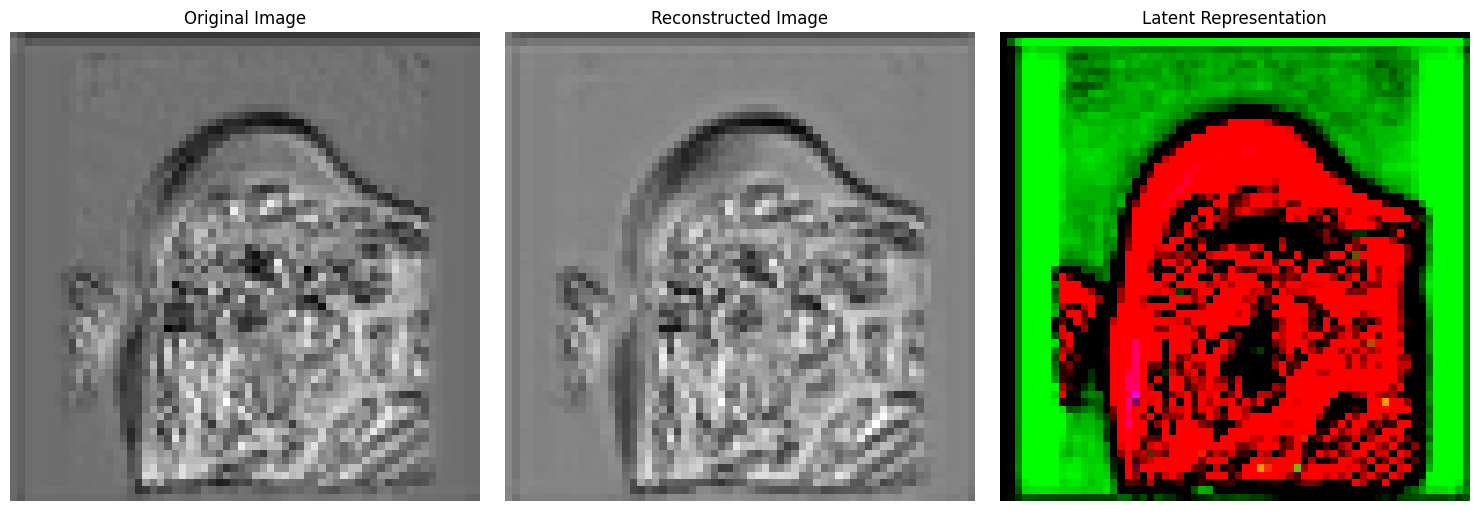

In [44]:
plot_results(original_np, reconstructed_np, latent_np)

In [45]:
mse_error = np.mean((original_np - reconstructed_np) ** 2)

print(f"MSE Error: {mse_error.item()}")

MSE Error: 0.03969573974609375


### Save  & load the autoencoder

In [46]:
from model_saver import ModelSaver

FILE_NAME = 'simple_encoder_e50'

saver = ModelSaver('./simple_autoencoders')

saver.save_model_config(autoencoder_dataset, file_name=FILE_NAME)

Model saved to ./simple_autoencoders/simple_encoder_e50.pth


Load saved autoencoder

In [38]:
# Initialize the same autoencoder structure
autoencoder_saved = FeatureAutoencoder(C, OUT_DIMS)
saver.load_autoencoder_config(autoencoder_saved, FILE_NAME)

defined an autoencoder with input channels=16 and out channels=3
Autoencoder loaded successfully


/home/keller/repos/MedImSeg-Lab24/src/dimensionality_reduction/../dimensionality_reduction/save_utils.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_s